In [1]:
import argparse
import os
from ast import arg

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

from wlcorr import EncoderDecoderStaticDataset, EncoderDecoder1DCNN

from matplotlib import pyplot as plt
import numpy as np

In [2]:
class VRLoss(nn.Module):

    def __init__(self, w_cos1 = 50, w_cos2 = 50, w_l2 = 25) -> None:
        super().__init__()
        self.cosinesim1 = nn.CosineSimilarity(dim=1, eps=1e-6)
        self.cosinesim2 = nn.CosineSimilarity(dim=2, eps=1e-6)
        self.l2 = nn.MSELoss()
        s = w_cos1 + w_cos2 + w_l2
        self.w_cos1, self.w_cos2, self.w_l2 = w_cos1/s, w_cos2/s, w_l2/s

    def forward(self, output:torch.Tensor, target:torch.Tensor):
        b, n, _ = output.shape
        sim1 = -self.cosinesim1(output, target)
        sim2 = -self.cosinesim2(output, target)
        l2 = self.l2(output, target)

        l = self.w_cos1*(sim1.exp().mean()-1e-1) + self.w_cos2*(sim2.exp().mean()-1e-1) + self.w_l2*l2
        
        return l

In [3]:
dataset = EncoderDecoderStaticDataset('/home/shivam/DKLabs/OilGasProject/WellLogCorrelation/data')
dataloader = DataLoader(dataset, batch_size = 10, shuffle = True, num_workers = 4)
data_len = len(dataloader)
log_n = int(data_len//2)

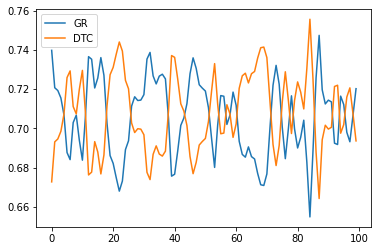

In [4]:
sample_data = dataset.__getitem__(0)
plt.plot(sample_data[0, :], label='GR')
plt.plot(sample_data[1, :], label='DTC')
plt.legend()
plt.show()

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
model = EncoderDecoder1DCNN(2, 50)
model.to(device)
model.train()

EncoderDecoder1DCNN(
  (encoder): Sequential(
    (0): Conv1d(2, 5, kernel_size=(10,), stride=(1,), padding=(9,))
    (1): SELU()
    (2): Conv1d(5, 10, kernel_size=(10,), stride=(1,), padding=(9,))
    (3): SELU()
    (4): Conv1d(10, 10, kernel_size=(10,), stride=(1,), padding=(9,))
    (5): SELU()
    (6): Conv1d(10, 10, kernel_size=(10,), stride=(1,), padding=(9,))
    (7): SELU()
    (8): Conv1d(10, 1, kernel_size=(10,), stride=(1,), padding=(9,))
    (9): SELU()
    (10): Linear(in_features=145, out_features=50, bias=True)
  )
  (decoder): Sequential(
    (0): ConvTranspose1d(1, 5, kernel_size=(10,), stride=(1,))
    (1): SELU()
    (2): ConvTranspose1d(5, 10, kernel_size=(10,), stride=(1,))
    (3): SELU()
    (4): ConvTranspose1d(10, 10, kernel_size=(10,), stride=(1,))
    (5): SELU()
    (6): ConvTranspose1d(10, 5, kernel_size=(10,), stride=(1,))
    (7): SELU()
    (8): ConvTranspose1d(5, 5, kernel_size=(10,), stride=(1,))
    (9): SELU()
    (10): ConvTranspose1d(5, 2, kernel

In [7]:
criterion =  VRLoss() # Loss function
params_list = model.parameters() # model parameters
optimizer = optim.AdamW(params_list, lr = 0.0007, weight_decay=0.0001)

In [8]:
def compute_loss(dl, model, crt):
    total_loss = 0.
    cnt = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in dl:
            data = data.to(device)
            
            # calculate outputs by running images through the network
            output = model(data)

            loss = crt(output, data)
            
            # print(predicted, labels)
            total_loss += loss.item()*data.size(0)
            cnt += data.size(0)
    return total_loss/cnt

In [9]:
rll = []
total_loss = []

In [10]:
model.train()
for epoch in range(500):
    running_loss = 0.0
    for i, data in enumerate(dataloader):
        data = data.to(device) # Move data to target device

        # zero the parameter gradients
        optimizer.zero_grad()

        output = model(data)
        loss = criterion(output, data)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if i%log_n == log_n-1:
            rll += [epoch, i, running_loss]
            print(f'Epoch : {epoch}, Iteration : {i},Running loss : {running_loss}')
            running_loss = 0
    total_loss += [compute_loss(dataloader, model, criterion)]
    print(f'Total loss : {total_loss[-1]}')

Epoch : 0, Iteration : 4,Running loss : 3.1608368158340454
Epoch : 0, Iteration : 9,Running loss : 2.0163530111312866
Total loss : 0.3287250204962127
Epoch : 1, Iteration : 4,Running loss : 1.5313418507575989
Epoch : 1, Iteration : 9,Running loss : 1.3406479805707932
Total loss : 0.24826458826357004
Epoch : 2, Iteration : 4,Running loss : 1.2104579508304596
Epoch : 2, Iteration : 9,Running loss : 1.2037106454372406
Total loss : 0.23753167688846588
Epoch : 3, Iteration : 4,Running loss : 1.1701852530241013
Epoch : 3, Iteration : 9,Running loss : 1.1387361288070679
Total loss : 0.22754388804338416
Epoch : 4, Iteration : 4,Running loss : 1.1581245064735413
Epoch : 4, Iteration : 9,Running loss : 1.188933104276657
Total loss : 0.23316763523890047
Epoch : 5, Iteration : 4,Running loss : 1.1809875071048737
Epoch : 5, Iteration : 9,Running loss : 1.113700419664383
Total loss : 0.22697822962488448
Epoch : 6, Iteration : 4,Running loss : 1.129251018166542
Epoch : 6, Iteration : 9,Running loss :

Epoch : 54, Iteration : 4,Running loss : 1.1247793138027191
Epoch : 54, Iteration : 9,Running loss : 1.10176582634449
Total loss : 0.22233821177969174
Epoch : 55, Iteration : 4,Running loss : 1.0905870497226715
Epoch : 55, Iteration : 9,Running loss : 1.1449227333068848
Total loss : 0.22768239190383832
Epoch : 56, Iteration : 4,Running loss : 1.104015365242958
Epoch : 56, Iteration : 9,Running loss : 1.0994079411029816
Total loss : 0.2248061831508364
Epoch : 57, Iteration : 4,Running loss : 1.136521264910698
Epoch : 57, Iteration : 9,Running loss : 1.1024374067783356
Total loss : 0.22713759845616865
Epoch : 58, Iteration : 4,Running loss : 1.1406791508197784
Epoch : 58, Iteration : 9,Running loss : 1.1090235114097595
Total loss : 0.22395218574270911
Epoch : 59, Iteration : 4,Running loss : 1.1083040982484818
Epoch : 59, Iteration : 9,Running loss : 1.1186045855283737
Total loss : 0.22101087685750456
Epoch : 60, Iteration : 4,Running loss : 1.1362760663032532
Epoch : 60, Iteration : 9,R

Total loss : 0.22339046700876586
Epoch : 108, Iteration : 4,Running loss : 1.10185144841671
Epoch : 108, Iteration : 9,Running loss : 1.1414330750703812
Total loss : 0.2235218116215297
Epoch : 109, Iteration : 4,Running loss : 1.125560685992241
Epoch : 109, Iteration : 9,Running loss : 1.1178371459245682
Total loss : 0.21916460808442564
Epoch : 110, Iteration : 4,Running loss : 1.1263018697500229
Epoch : 110, Iteration : 9,Running loss : 1.1022700518369675
Total loss : 0.22049854087586307
Epoch : 111, Iteration : 4,Running loss : 1.092093899846077
Epoch : 111, Iteration : 9,Running loss : 1.1160080581903458
Total loss : 0.22316045025173498
Epoch : 112, Iteration : 4,Running loss : 1.0904063433408737
Epoch : 112, Iteration : 9,Running loss : 1.1261847913265228
Total loss : 0.22178123374374545
Epoch : 113, Iteration : 4,Running loss : 1.0999315679073334
Epoch : 113, Iteration : 9,Running loss : 1.116882786154747
Total loss : 0.22336747634167575
Epoch : 114, Iteration : 4,Running loss : 1

Epoch : 161, Iteration : 4,Running loss : 1.1386751681566238
Epoch : 161, Iteration : 9,Running loss : 1.1072921007871628
Total loss : 0.22542724469486547
Epoch : 162, Iteration : 4,Running loss : 1.0787119269371033
Epoch : 162, Iteration : 9,Running loss : 1.101809412240982
Total loss : 0.22285400422251955
Epoch : 163, Iteration : 4,Running loss : 1.101501688361168
Epoch : 163, Iteration : 9,Running loss : 1.1551698595285416
Total loss : 0.22306592671238645
Epoch : 164, Iteration : 4,Running loss : 1.1020721942186356
Epoch : 164, Iteration : 9,Running loss : 1.1255269050598145
Total loss : 0.2202891357699219
Epoch : 165, Iteration : 4,Running loss : 1.141274556517601
Epoch : 165, Iteration : 9,Running loss : 1.0906906425952911
Total loss : 0.22293536669137526
Epoch : 166, Iteration : 4,Running loss : 1.1002989560365677
Epoch : 166, Iteration : 9,Running loss : 1.1130059361457825
Total loss : 0.22404951739067935
Epoch : 167, Iteration : 4,Running loss : 1.1138752400875092
Epoch : 167, 

Epoch : 214, Iteration : 9,Running loss : 1.112727329134941
Total loss : 0.22260649836793237
Epoch : 215, Iteration : 4,Running loss : 1.1634842306375504
Epoch : 215, Iteration : 9,Running loss : 1.0999359339475632
Total loss : 0.22124081910872945
Epoch : 216, Iteration : 4,Running loss : 1.099993959069252
Epoch : 216, Iteration : 9,Running loss : 1.0883236229419708
Total loss : 0.22266716403620584
Epoch : 217, Iteration : 4,Running loss : 1.0749879032373428
Epoch : 217, Iteration : 9,Running loss : 1.1033984273672104
Total loss : 0.22391106583634202
Epoch : 218, Iteration : 4,Running loss : 1.086843341588974
Epoch : 218, Iteration : 9,Running loss : 1.1117569357156754
Total loss : 0.22400579616731528
Epoch : 219, Iteration : 4,Running loss : 1.1131655126810074
Epoch : 219, Iteration : 9,Running loss : 1.0872592329978943
Total loss : 0.2237860098177073
Epoch : 220, Iteration : 4,Running loss : 1.1255984008312225
Epoch : 220, Iteration : 9,Running loss : 1.0918850302696228
Total loss : 

Total loss : 0.22636844278598317
Epoch : 268, Iteration : 4,Running loss : 1.100833386182785
Epoch : 268, Iteration : 9,Running loss : 1.1280080676078796
Total loss : 0.22252218698968693
Epoch : 269, Iteration : 4,Running loss : 1.111843392252922
Epoch : 269, Iteration : 9,Running loss : 1.1305049061775208
Total loss : 0.22538445555433936
Epoch : 270, Iteration : 4,Running loss : 1.1125371754169464
Epoch : 270, Iteration : 9,Running loss : 1.086581438779831
Total loss : 0.21869781978276312
Epoch : 271, Iteration : 4,Running loss : 1.1116451621055603
Epoch : 271, Iteration : 9,Running loss : 1.1137567907571793
Total loss : 0.2199371371950422
Epoch : 272, Iteration : 4,Running loss : 1.1127538830041885
Epoch : 272, Iteration : 9,Running loss : 1.1258243322372437
Total loss : 0.21861580166281486
Epoch : 273, Iteration : 4,Running loss : 1.0884401053190231
Epoch : 273, Iteration : 9,Running loss : 1.099466010928154
Total loss : 0.22253379408194093
Epoch : 274, Iteration : 4,Running loss : 

Epoch : 321, Iteration : 4,Running loss : 1.1112636178731918
Epoch : 321, Iteration : 9,Running loss : 1.0862611383199692
Total loss : 0.2200417673709441
Epoch : 322, Iteration : 4,Running loss : 1.0987661182880402
Epoch : 322, Iteration : 9,Running loss : 1.143959566950798
Total loss : 0.2227565758690542
Epoch : 323, Iteration : 4,Running loss : 1.1119364798069
Epoch : 323, Iteration : 9,Running loss : 1.1181775778532028
Total loss : 0.2211247192961829
Epoch : 324, Iteration : 4,Running loss : 1.124989002943039
Epoch : 324, Iteration : 9,Running loss : 1.1118410527706146
Total loss : 0.22381275314457563
Epoch : 325, Iteration : 4,Running loss : 1.074321061372757
Epoch : 325, Iteration : 9,Running loss : 1.1129612773656845
Total loss : 0.22502282383490582
Epoch : 326, Iteration : 4,Running loss : 1.074388548731804
Epoch : 326, Iteration : 9,Running loss : 1.111737310886383
Total loss : 0.2224946356549555
Epoch : 327, Iteration : 4,Running loss : 1.0750643163919449
Epoch : 327, Iteratio

Epoch : 374, Iteration : 9,Running loss : 1.0992768555879593
Total loss : 0.22236608242502018
Epoch : 375, Iteration : 4,Running loss : 1.1655208319425583
Epoch : 375, Iteration : 9,Running loss : 1.1015882194042206
Total loss : 0.2202043898251592
Epoch : 376, Iteration : 4,Running loss : 1.0866370499134064
Epoch : 376, Iteration : 9,Running loss : 1.1412892192602158
Total loss : 0.2186076735355416
Epoch : 377, Iteration : 4,Running loss : 1.1255741566419601
Epoch : 377, Iteration : 9,Running loss : 1.0874251276254654
Total loss : 0.2252429675082771
Epoch : 378, Iteration : 4,Running loss : 1.0859624594449997
Epoch : 378, Iteration : 9,Running loss : 1.0984702408313751
Total loss : 0.21919209160366837
Epoch : 379, Iteration : 4,Running loss : 1.0993978530168533
Epoch : 379, Iteration : 9,Running loss : 1.0868754982948303
Total loss : 0.21735299150554502
Epoch : 380, Iteration : 4,Running loss : 1.1371454894542694
Epoch : 380, Iteration : 9,Running loss : 1.0870725065469742
Total loss :

Total loss : 0.22235097325578027
Epoch : 428, Iteration : 4,Running loss : 1.0859543085098267
Epoch : 428, Iteration : 9,Running loss : 1.126724824309349
Total loss : 0.22233681958548876
Epoch : 429, Iteration : 4,Running loss : 1.135814055800438
Epoch : 429, Iteration : 9,Running loss : 1.089093565940857
Total loss : 0.22243864074045297
Epoch : 430, Iteration : 4,Running loss : 1.1109168529510498
Epoch : 430, Iteration : 9,Running loss : 1.1156626641750336
Total loss : 0.22117940503723768
Epoch : 431, Iteration : 4,Running loss : 1.13612662255764
Epoch : 431, Iteration : 9,Running loss : 1.1109317690134048
Total loss : 0.21979947236119485
Epoch : 432, Iteration : 4,Running loss : 1.0977065712213516
Epoch : 432, Iteration : 9,Running loss : 1.0988762974739075
Total loss : 0.22109565290869498
Epoch : 433, Iteration : 4,Running loss : 1.1106790453195572
Epoch : 433, Iteration : 9,Running loss : 1.10148024559021
Total loss : 0.2171897064058148
Epoch : 434, Iteration : 4,Running loss : 1.1

Epoch : 481, Iteration : 4,Running loss : 1.1359881609678268
Epoch : 481, Iteration : 9,Running loss : 1.1013146787881851
Total loss : 0.22105877709632016
Epoch : 482, Iteration : 4,Running loss : 1.0987998992204666
Epoch : 482, Iteration : 9,Running loss : 1.1015941500663757
Total loss : 0.2223302043822347
Epoch : 483, Iteration : 4,Running loss : 1.0874578803777695
Epoch : 483, Iteration : 9,Running loss : 1.126895248889923
Total loss : 0.22096698259820743
Epoch : 484, Iteration : 4,Running loss : 1.1111173182725906
Epoch : 484, Iteration : 9,Running loss : 1.0858584344387054
Total loss : 0.22236023600004157
Epoch : 485, Iteration : 4,Running loss : 1.0982912331819534
Epoch : 485, Iteration : 9,Running loss : 1.1549470275640488
Total loss : 0.2210506495772576
Epoch : 486, Iteration : 4,Running loss : 1.0855113565921783
Epoch : 486, Iteration : 9,Running loss : 1.1494374722242355
Total loss : 0.2211721585113175
Epoch : 487, Iteration : 4,Running loss : 1.110817238688469
Epoch : 487, I

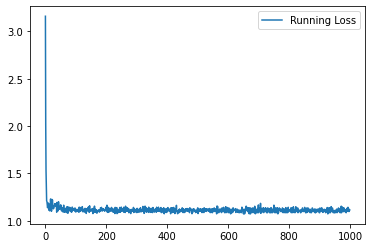

In [11]:
plt.plot(np.array(rll).reshape((-1, 3))[:, 2], label='Running Loss')
plt.legend()
plt.show()

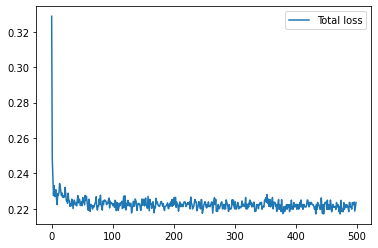

In [12]:
plt.plot(total_loss, label='Total loss')
plt.legend()
plt.show()

In [13]:
torch.save(model.state_dict(), './modelstate_vr_loss')

In [14]:
model.eval()

EncoderDecoder1DCNN(
  (encoder): Sequential(
    (0): Conv1d(2, 5, kernel_size=(10,), stride=(1,), padding=(9,))
    (1): SELU()
    (2): Conv1d(5, 10, kernel_size=(10,), stride=(1,), padding=(9,))
    (3): SELU()
    (4): Conv1d(10, 10, kernel_size=(10,), stride=(1,), padding=(9,))
    (5): SELU()
    (6): Conv1d(10, 10, kernel_size=(10,), stride=(1,), padding=(9,))
    (7): SELU()
    (8): Conv1d(10, 1, kernel_size=(10,), stride=(1,), padding=(9,))
    (9): SELU()
    (10): Linear(in_features=145, out_features=50, bias=True)
  )
  (decoder): Sequential(
    (0): ConvTranspose1d(1, 5, kernel_size=(10,), stride=(1,))
    (1): SELU()
    (2): ConvTranspose1d(5, 10, kernel_size=(10,), stride=(1,))
    (3): SELU()
    (4): ConvTranspose1d(10, 10, kernel_size=(10,), stride=(1,))
    (5): SELU()
    (6): ConvTranspose1d(10, 5, kernel_size=(10,), stride=(1,))
    (7): SELU()
    (8): ConvTranspose1d(5, 5, kernel_size=(10,), stride=(1,))
    (9): SELU()
    (10): ConvTranspose1d(5, 2, kernel

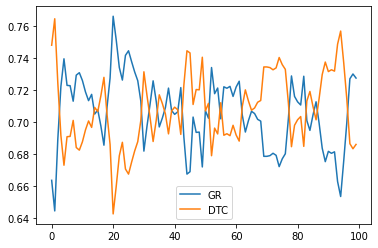

In [15]:
sample_data = dataset.__getitem__(0)
plt.plot(sample_data[0, :], label='GR')
plt.plot(sample_data[1, :], label='DTC')
plt.legend()
plt.show()

In [16]:
sample_data_ = sample_data.unsqueeze(dim=0).to(device)
reconst_data = model(sample_data_)
reconst_data = reconst_data.detach().cpu().squeeze(dim=0).numpy()

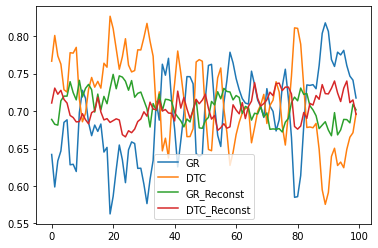

In [17]:
sample_data = dataset.__getitem__(0)
plt.plot(sample_data[0, :], label='GR')
plt.plot(sample_data[1, :], label='DTC')
plt.plot(reconst_data[0, :], label='GR_Reconst')
plt.plot(reconst_data[1, :], label='DTC_Reconst')
plt.legend()
plt.show()